# Data augmentation

## Overview

Trong bài sẽ đề cập đến 2 cách để thực hiện:
- Sử dụng `keras`:
  - `tf.keras.layers.Resizing`
  - `tf.keras.layers.Rescaling`
  - `tf.keras.layers.RandomFlip`
  - `tf.keras.layers.RandomRotation`

<br>

- Sử dụng `tf.image`:
  - `tf.image.flip_left_right`
  - `tf.image.rgb_to_grayscale`
  - `tf.image.adjust_brightness`
  - `tf.image.central_crop`
  - `tf.image.stateless_random*`

## Setup

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

## Download dataset

In [14]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=[
        tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
        tfds.Split.TRAIN.subsplit(tfds.percent[80:90]),
        tfds.Split.TRAIN.subsplit(tfds.percent[90:])
        ],
    with_info=True,
    as_supervised=True,
)

In [15]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


In [16]:
get_label_name = metadata.features['label'].int2str
get_label_name

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=5)>

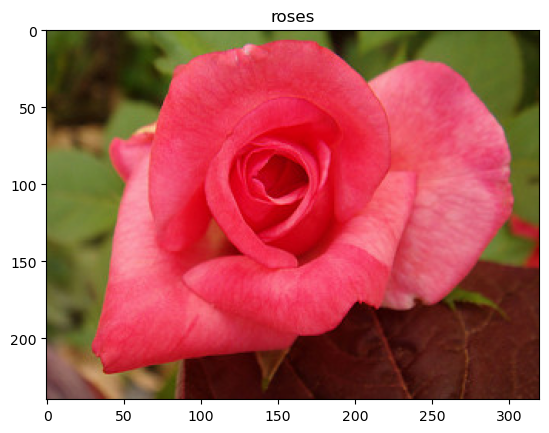

In [17]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [18]:
train_ds

<_OptionsDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Use Keras preprocessing layers

### Resizing and rescaling

  - `tf.keras.layers.Resizing`
  - `tf.keras.layers.Rescaling`

In [19]:
IMG_SIZE = 180

resize_and_scale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

Note: The rescaling layer above standardizes pixel values to the [0, 1] range. If instead you wanted it to be [-1, 1], you would write tf.keras.layers.Rescaling(1./127.5, offset=-1).

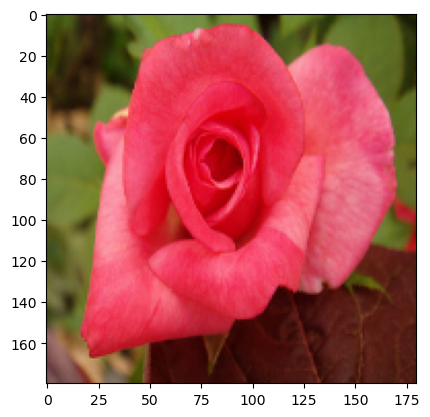

In [20]:
result = resize_and_scale(image)
_ = plt.imshow(result)

### Data augmentation

  - `tf.keras.layers.RandomFlip`
  - `tf.keras.layers.RandomRotation`

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [22]:
# Add the image to a batch
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

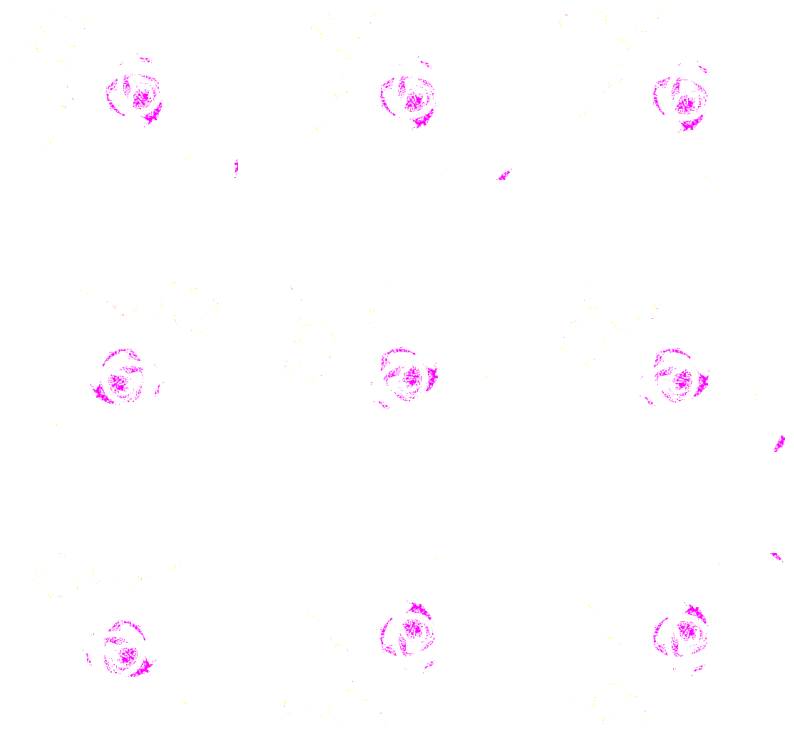

In [23]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

There are a variety of preprocessing layers you can use for data augmentation including `tf.keras.layers.RandomContrast`, `tf.keras.layers.RandomCrop`, `tf.keras.layers.RandomZoom`, and others.

### Two options to use the Keras preprocessing layers

#### Option 1: Make the preprocessing layers parts of your model

In [24]:
model = tf.keras.Sequential([
    resize_and_scale,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    # Rest of your model
])

Có 2 điểm quan trọng cần lưu ý trong trường hợp này:
- Data agumentation sẽ chạy trên thiết bị, đồng bộ với các lớp còn lại của bạn và được hưởng lợi từ việc tăng tốc GPU.
- Khi bạn xuất mô hình của mình bằng cách sử dụng `model.save`, các lớp tiền xử lý sẽ được lưu cùng với phần còn lại của mô hình của bạn. Nếu sau này bạn triển khai mô hình này, nó sẽ tự động chuẩn hóa hình ảnh (theo cấu hình của các lớp của bạn). Điều này có thể giúp bạn tiết kiệm khỏi nỗ lực phải thực hiện lại phía máy chủ logic đó.

Lưu ý: Tính năng tăng dữ liệu không hoạt động tại thời điểm thử nghiệm vì vậy hình ảnh đầu vào sẽ chỉ được tăng cường trong các cuộc gọi đến `Model.fit`(không `Model.evaluate` hoặc `Model.predict`).

#### Option 2: Apply the preprocessing layers to your dataset

In [25]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_scale(x, training=True), y))

Với cách tiếp cận này, bạn sử dụng `Dataset.map` để tạo tập dữ liệu mang lại các lô hình ảnh tăng cường. Trong trường hợp này:

- Việc tăng dữ liệu sẽ diễn ra không đồng bộ trên CPU và không bị chặn. Bạn có thể chồng chéo quá trình đào tạo mô hình của mình trên GPU với xử lý trước dữ liệu, sử dụng Dataset.prefetch , được hiển thị bên dưới.
- Trong trường hợp này, các lớp tiền xử lý sẽ không được xuất cùng với mô hình khi bạn gọi `Model.save` . Bạn sẽ cần đính kèm chúng vào mô hình của mình trước khi lưu hoặc thực hiện lại chúng ở phía máy chủ. Sau khi đào tạo, bạn có thể đính kèm các lớp tiền xử lý trước khi xuất.
Bạn có thể tìm thấy một ví dụ về tùy chọn đầu tiên trong hướng dẫn phân loại Hình ảnh . Hãy chứng minh tùy chọn thứ hai ở đây.

### Apply the preprocessing layers to the datasets

**Note:** Data augmentation should only be applied to the training set.

In [26]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
      # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_scale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [27]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Training a model

In [28]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
93/93 [==============================] - 48s 487ms/step - loss: 1.2843 - accuracy: 0.4410 - val_loss: 1.1600 - val_accuracy: 0.4972
Epoch 2/5
93/93 [==============================] - 46s 478ms/step - loss: 1.0823 - accuracy: 0.5614 - val_loss: 1.0280 - val_accuracy: 0.6000
Epoch 3/5
93/93 [==============================] - 46s 479ms/step - loss: 0.9801 - accuracy: 0.6153 - val_loss: 0.9149 - val_accuracy: 0.6417
Epoch 4/5
93/93 [==============================] - 43s 450ms/step - loss: 0.9183 - accuracy: 0.6407 - val_loss: 0.8792 - val_accuracy: 0.6500
Epoch 5/5
93/93 [==============================] - 42s 441ms/step - loss: 0.8617 - accuracy: 0.6610 - val_loss: 0.8960 - val_accuracy: 0.6639


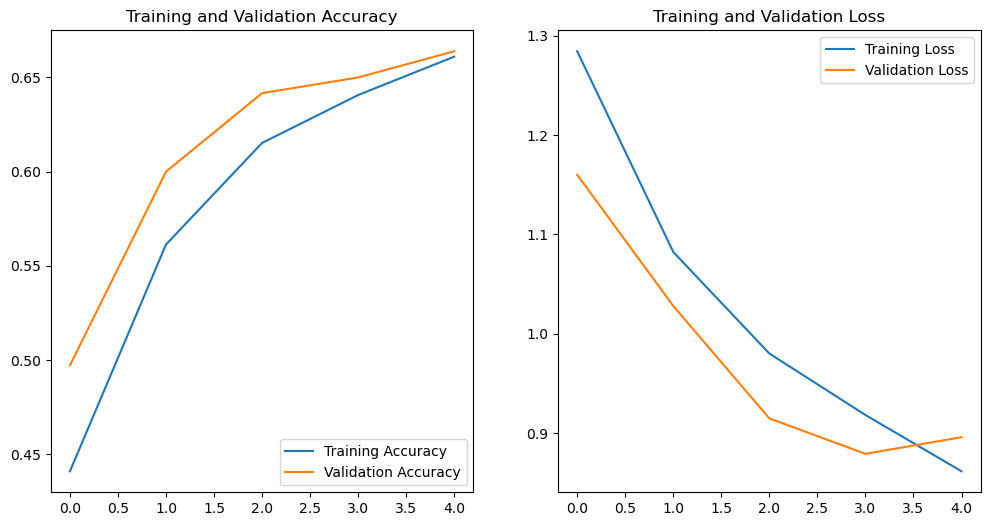

In [32]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  
plot_history(history)

In [33]:
loss, acc = model.evaluate(test_ds)

12/12 [==============================] - 2s 125ms/step - loss: 0.8687 - accuracy: 0.6528


### Custom data augmentation

You can also create custom data augmentation layers.

This section of the tutorial shows two ways of doing so:

- First, you will create a `tf.keras.layers.Lambda` layer. This is a good way to write concise code.
- Next, you will write a new layer via subclassing, which gives you more control.
Both layers will randomly invert the colors in an image, according to some probability.

In [34]:
def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x

def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

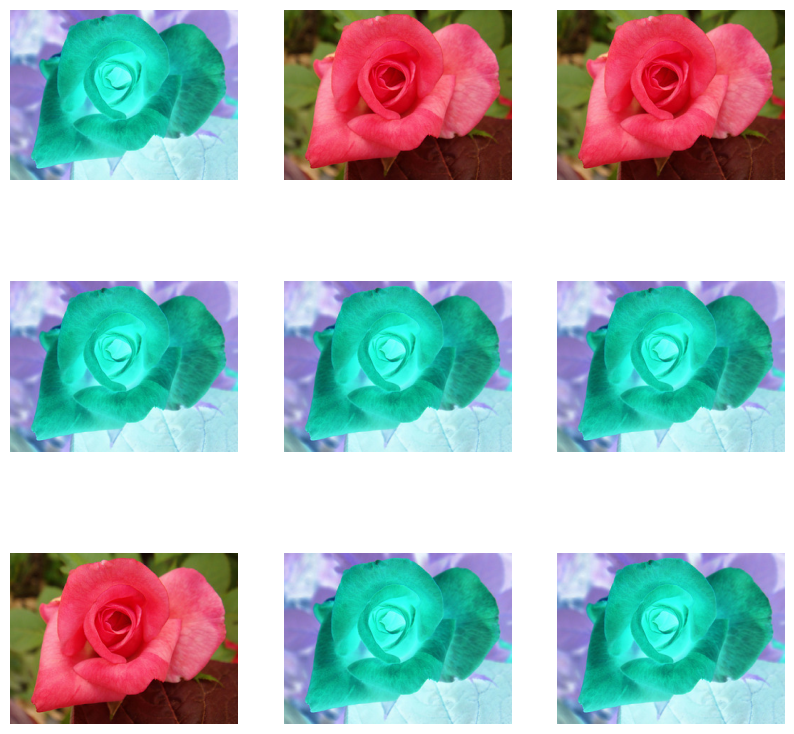

In [35]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by subclassing:

In [36]:
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

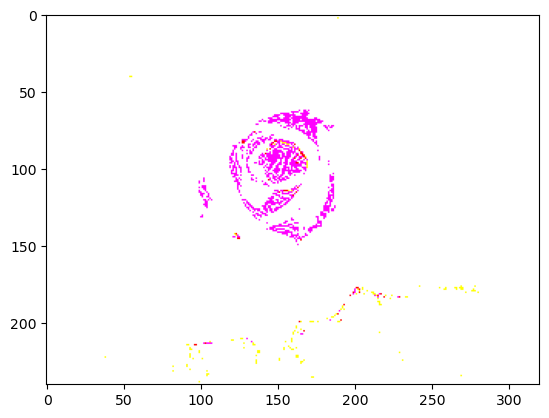

In [37]:
_ = plt.imshow(RandomInvert()(image)[0])

## Using `tf.image`

The above Keras preprocessing utilities are convenient. 

But, for finer control, you can write your own `data augmentation pipelines` or `layers` using `tf.data` and `tf.image`. (You may also want to check out *TensorFlow Addons Image: Operations* and *TensorFlow I/O: Color Space Conversions*.)

[Official document](https://www.tensorflow.org/tutorials/images/data_augmentation#using_tfimage)

[Tensorflow Addon Image: Operations](https://www.tensorflow.org/addons/tutorials/image_ops)

[Color Space Conversions](https://www.tensorflow.org/io/tutorials/colorspace)